In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-oct-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-oct-2021/train.csv
/kaggle/input/tabular-playground-series-oct-2021/test.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install scikit-learn  -U

     |████████████████████████████████| 23.1 MB 826 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.3 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0 which is incompatible.


In [4]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

2021-10-18 02:57:33.857482: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [5]:
seed = 47

# Tabular Playground Series - Oct 2021

The tabular series on kaggle are meant to help novices in data science field like me get acquainted with kaggle competitions.

The dataset created for this competition is synthetic, but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting the biological response of molecules given various chemical properties.

The first step in almost every data science project is to perfom some exploratory data analysis, which is already done in a previous notebook [1]. Here we will try to use some assumption based on that analysis to
verify whether we can obtaion better performance. To begin with, we will use only 100k samples of the original data. Here we try some baseline models and also do some grid search on some data transformation methods.

[1] https://www.kaggle.com/peressim/tabular-playground-series-oct-2021-eda

In [6]:
def evaluate_model(model, x, y):
    y_pred = model.predict(x)
    y_pred_prob = model.predict_proba(x)[:, 1]
    auc_roc = roc_auc_score(y, y_pred_prob)
    return {'auc_roc_curve' : auc_roc}

In [7]:
random.seed(seed)
n = 1000000
s = 100000
skip = sorted(random.sample(range(n),n-s))

train_df = pd.read_csv('/kaggle/input/tabular-playground-series-oct-2021/train.csv', sep=',', skiprows=skip)

In [8]:
train_df.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
0,5,0.255237,0.345842,0.021549,0.220755,0.524854,0.423693,0.533150,0.628484,0.340781,...,0,0,1,0,1,0,0,0,0,0
1,9,0.180916,0.450976,0.170291,0.356205,0.924490,0.491684,0.465108,0.652863,0.294830,...,0,0,0,0,0,0,0,0,0,0
2,10,0.183644,0.374077,0.178906,0.244896,0.576364,0.495866,0.510860,0.610363,0.387875,...,0,0,0,0,0,0,0,1,0,0
3,24,0.161543,0.520489,0.093829,0.254242,0.662581,0.470565,0.488163,0.599764,0.520008,...,0,0,0,0,0,1,0,1,0,0
4,25,0.224420,0.407032,0.163269,0.331523,0.771134,0.341357,0.363220,0.599637,0.468193,...,0,0,0,0,0,0,0,1,0,1


In [9]:
print('Dataset shape: ', train_df.shape )

Dataset shape:  (100000, 287)


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 287 entries, id to target
dtypes: float64(240), int64(47)
memory usage: 219.0 MB


Text(0, 0.5, 'Count')

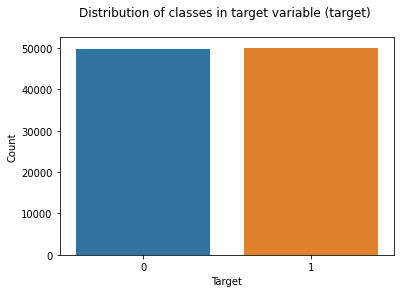

In [11]:
# Sanity check for balanced number of classes in the target variable

sns.countplot(train_df['target'])
plt.title('Distribution of classes in target variable (target) \n')
plt.xlabel('Target')
plt.ylabel('Count')

# Data splitting

Here we split the data into train and test sets

In [12]:
def get_train_test_split(test_size=0.2):
    x_train = train_df.drop(['id', 'target'], axis=1).values
    y_train = train_df['target'].values 
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = test_size, random_state = seed)

    print('x_train', x_train.shape, 'y_train', y_train.shape)
    print('x_test', x_test.shape, 'y_test', y_test.shape)
    return x_train, x_test, y_train, y_test

In [13]:
x_train, x_test, y_train, y_test = get_train_test_split()

x_train (80000, 285) y_train (80000,)
x_test (20000, 285) y_test (20000,)


# Baseline

Baseline models to choose the methods that will allow the model to achieve a good performance.

1 - Logistic Regression

2 - XGBoost

All the tests will be based on a fraction of 10% of all available data

# Experiment - 1

Here we just test the performance of logistic regression and an xgboost without in the dataset as it is. No preprocessing in the data is performed.

In [14]:
print("Fitting a simple Logistic Regression model")
model = LogisticRegression(random_state=seed, solver='liblinear')
model.fit(x_train, y_train)
model.score(x_test, y_test)
results = evaluate_model(model, x_test, y_test)
print(results)

Fitting a simple Logistic Regression model
{'auc_roc_curve': 0.8402874041382506}


In [15]:
print("Fitting XGBoost Classifier")
model = XGBClassifier(random_state=0, tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False, verbosity=0)
model.fit(x_train, y_train)
results = evaluate_model(model, x_test, y_test)
print(results)

Fitting XGBoost Classifier
{'auc_roc_curve': 0.8378130936450079}


# GridCV on Data Preparation

Before doing anything else with the baseline models, we will perform a grid search on data preprocessing techniques.

References:

    [1]  https://machinelearningmastery.com/grid-search-data-preparation-techniques/

In [16]:
# get modeling pipelines to evaluate
def get_pipelines(model):
    pipelines = list()
    # normalize
    p = Pipeline([('s',MinMaxScaler()), ('m',model)])
    pipelines.append(('norm', p))
    # standardize
    p = Pipeline([('s',StandardScaler()), ('m',model)])
    pipelines.append(('std', p))
    # quantile
    p = Pipeline([('s',QuantileTransformer(n_quantiles=100, output_distribution='normal')), ('m',model)])
    pipelines.append(('quan', p))
    # pca
    p = Pipeline([('s',PCA()), ('m',model)])
    pipelines.append(('pca', p))
    # svd
    p = Pipeline([('s',TruncatedSVD()), ('m',model)])
    pipelines.append(('svd', p))
    
    p = Pipeline([('s',StandardScaler()), ('p', PowerTransformer()), ('m',model)])
    pipelines.append(('std-power', p))
    # scale and power
    p = Pipeline([('s',MinMaxScaler()), ('p', PowerTransformer()), ('m',model)])
    pipelines.append(('min-max-power', p))
    
    p = Pipeline([('p', PowerTransformer()), ('m',model)])
    pipelines.append(('power', p))
    
    return pipelines

In [17]:
def score_model(x, y, model):
    # define the cross-validation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, x, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores

# Logistic Regression - Pipelines

In [18]:
model = LogisticRegression(random_state=seed, solver='liblinear')
pipelines = get_pipelines(model)
x_train = train_df.drop(['id', 'target'], axis=1).values
y_train = train_df['target'].values 

# evaluate each pipeline
results, names = list(), list()
for name, pipeline in pipelines:
	# evaluate
	scores = score_model(x_train, y_train, pipeline)
	# summarize
	print('>%s: %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
	# store
	results.append(scores)
	names.append(name)

# No Transform
scores = score_model(x_train, y_train, model)
print('>%s: %.3f (%.3f)' % ('No-transform', np.mean(scores), np.std(scores)))
results.append(scores)
names.append('No-transform')

>norm: 0.839 (0.004)
>std: 0.839 (0.004)
>quan: 0.834 (0.005)
>pca: 0.839 (0.004)
>svd: 0.613 (0.032)
>std-power: 0.846 (0.004)
>min-max-power: 0.847 (0.004)
>power: 0.847 (0.004)
>No-transform: 0.839 (0.004)


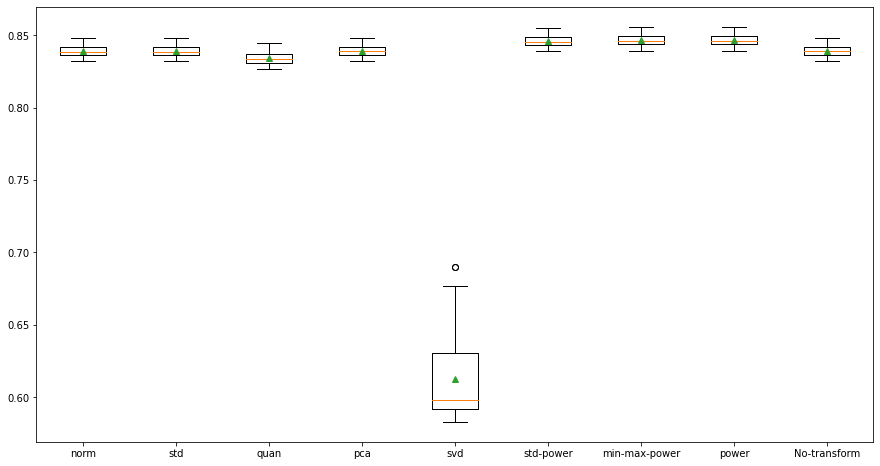

In [19]:
plt.figure(figsize=(15,8))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

# XGBoost - Pipelines

In [20]:
# model = XGBClassifier(random_state=seed, verbosity=0)
model = XGBClassifier(random_state=seed, tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False, verbosity=0)
pipelines = get_pipelines(model)
x_train = train_df.drop(['id', 'target'], axis=1).values
y_train = train_df['target'].values 

# evaluate each pipeline
results, names = list(), list()
for name, pipeline in pipelines:
	# evaluate
	scores = score_model(x_train, y_train, pipeline)
	# summarize
	print('>%s: %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
	# store
	results.append(scores)
	names.append(name)

# No Transform
scores = score_model(x_train, y_train, model)
print('>%s: %.3f (%.3f)' % ('No-transform', np.mean(scores), np.std(scores)))
results.append(scores)
names.append('No-transform')

>norm: 0.838 (0.004)
>std: 0.838 (0.004)
>quan: 0.838 (0.004)
>pca: 0.822 (0.004)
>svd: 0.593 (0.037)
>std-power: 0.838 (0.004)
>min-max-power: 0.838 (0.004)
>power: 0.838 (0.004)
>No-transform: 0.838 (0.004)


In [21]:
r = dict(zip(names, np.mean(results, axis=1).tolist()))
n = max(r, key=r.get)
print(n, r[n])
dict(zip(names, np.mean(results, axis=1).tolist()))

min-max-power 0.8381329887769137


{'norm': 0.8377206101805252,
 'std': 0.8377206101805252,
 'quan': 0.8377944452054013,
 'pca': 0.8215059923012358,
 'svd': 0.5931877592874406,
 'std-power': 0.8375887583128379,
 'min-max-power': 0.8381329887769137,
 'power': 0.8381110540864248,
 'No-transform': 0.8377206101805252}

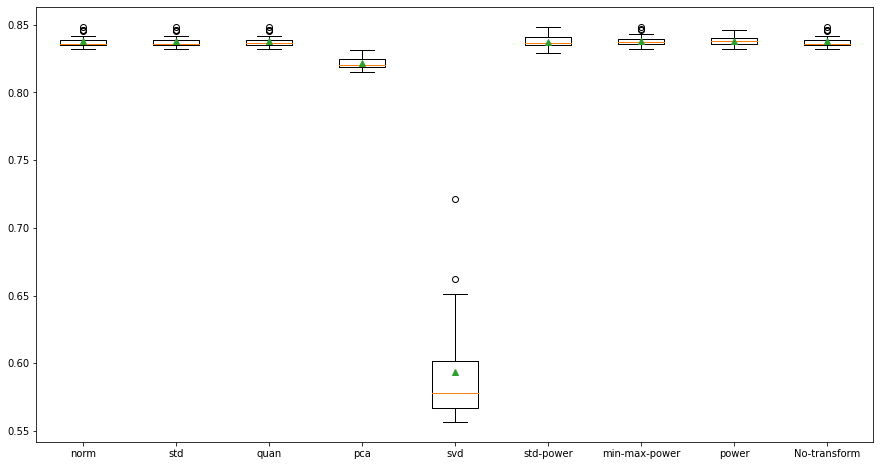

In [22]:
plt.figure(figsize=(15,8))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

# Results

<h3>Best results</h3>

Logistic Regression when used with PowerTransformer overcome all the XGBoost.
XGBoost - No transform (any other transformation gives the same result, except when it is used with svd)


# Feature engineering - Creating some synthetic features

# Logistic regression

We create synthetic features and use power transform as well

In [23]:
geomean = lambda x, axis : np.exp(np.mean(np.log(x), axis=axis))
harmonic_mean = lambda x, axis : len(x) / np.sum(1.0/x, axis=axis) 

funcs = {'mean' : np.mean, 
         'std' : np.std, 
         'var' : np.var, 
         'geo_mean' : geomean, 
         'harmonic_mean' : harmonic_mean, 
         'median' : np.median}

In [24]:
results, names = list(), list()
p = PowerTransformer()

for key in funcs.keys():
    x = train_df.drop(['id', 'target'], axis=1)
    x[key] = funcs[key](x, axis=1)
    y = train_df['target']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = seed)
    x_train = p.fit_transform(x_train)
    x_test = p.transform(x_test)
    model = LogisticRegression(random_state=seed, solver='liblinear')
    
    model.fit(x_train, y_train)
    model.score(x_test, y_test)
    result = evaluate_model(model, x_test, y_test)
    names.append(key)
    results.append(result['auc_roc_curve'])

for name, score in zip(names, results):
    print('>%s: %f' % (name, score))

>mean: 0.848562
>std: 0.848603
>var: 0.848603
>geo_mean: 0.848507
>harmonic_mean: 0.848507
>median: 0.848406


# XGBoost Classifier

In [25]:
results, names = list(), list()

for key in funcs.keys():
    x = train_df.drop(['id', 'target'], axis=1)
    x[key] = funcs[key](x, axis=1)
    y = train_df['target']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = seed)
    model = XGBClassifier(random_state=0, tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False, verbosity=0)
    
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    names.append(key)
    results.append(result['auc_roc_curve'])

for name, score in zip(names, results):
    print('>%s: %f' % (name, score))

>mean: 0.837101
>std: 0.837891
>var: 0.838206
>geo_mean: 0.837813
>harmonic_mean: 0.837813
>median: 0.837247


Logistic regression showed the best results. It seems to work well with mean or std, however std was almost identical it was a little better than the mean. XGboost present the best result with the var as synthetic feature. 

Logistic - std

XGboost - var

In [26]:
del x, y
gc.collect()

18772

# Grid Search

References:

    [1] https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

# Logistic Regression

In [27]:
p = PowerTransformer()
x_train = train_df.drop(['id', 'target'], axis=1)
x_train['std'] = np.std(x_train, axis=1)
y_train = train_df['target']
x_train = p.fit_transform(x_train)

In [28]:
space = dict()
space['solver'] = ['liblinear', 'newton-cg', 'lbfgs']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
model = LogisticRegression(random_state=seed, verbose=0)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
search = GridSearchCV(model, space, scoring='roc_auc', n_jobs=-1, cv=cv)

In [29]:
result = search.fit(x_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

Best Score: 0.8470041623921155
Best Hyperparameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


In [30]:
result.best_estimator_

LogisticRegression(C=0.01, penalty='l1', random_state=47, solver='liblinear')

# XGBoost Classifier

In [31]:
p = PowerTransformer()
x_train = train_df.drop(['id', 'target'], axis=1)
x_train['var'] = np.var(x_train, axis=1)
y_train = train_df['target']
x_train = p.fit_transform(x_train)

In [32]:
params = {'n_estimators' : [1000, 1290, 1295, 1300, 1305, 1310, 1315, 1325],
          'max_depth' : [3, 4],
          'subsample' : [0.8, 0.9, 1.0],
          'eta' : [0.12],
          'colsample_bytree' : [0.3, 0.4],
          'min_child_weight': [5],
          'gamma': [5],
         }

model = XGBClassifier(random_state=seed, tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False, verbosity=0)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
search = GridSearchCV(model, param_grid=params, scoring='roc_auc', refit='roc_auc', n_jobs=-1, cv=cv)

In [33]:
result = search.fit(x_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The 

Best Score: 0.8531397622868944
Best Hyperparameters: {'colsample_bytree': 0.3, 'eta': 0.12, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 1000, 'subsample': 1.0}


# Individual Search on Full data set

Now with best params, we will do an individual search on the full dataset since we were using only 10% in the grid search.

In [34]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-oct-2021/train.csv', sep=',')

In [35]:
p = PowerTransformer()
x_train = train_df.drop(['id', 'target'], axis=1)
x_train['var'] = np.var(x_train, axis=1)
y_train = train_df['target']
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2, random_state = seed)
x_train = p.fit_transform(x_train)
x_test = p.transform(x_test)

In [36]:
params = result.best_params_.copy()
print(params)

{'colsample_bytree': 0.3, 'eta': 0.12, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 1000, 'subsample': 1.0}


<h3>1 - Testing different number of estimators</h3>

In [37]:
results_trees = {}
trees = [100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 950, 975, 1000, 1025, 1050, 1100, 1150, 1290, 1295, 1300, 1305, 1310, 1315, 1325, 2000]
for n in trees:
    params['n_estimators'] = n
    model = XGBClassifier(**params, random_state=seed, tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False, verbosity=0)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_trees[n] = result['auc_roc_curve']
    print('n_estimators:', n, 'auc_roc_curve:', results_trees[n])

best_nestimator = max(results_trees, key=results_trees.get)
print('\nBest n_estimators:', best_nestimator, 'AUCROC score:', results_trees[best_nestimator])

n_estimators: 100 auc_roc_curve: 0.8453085834033844
n_estimators: 150 auc_roc_curve: 0.8491323028943352
n_estimators: 200 auc_roc_curve: 0.8511798847506142
n_estimators: 250 auc_roc_curve: 0.8525180790870425
n_estimators: 300 auc_roc_curve: 0.853576663571131
n_estimators: 350 auc_roc_curve: 0.8542527482156432
n_estimators: 400 auc_roc_curve: 0.8548345160551847
n_estimators: 450 auc_roc_curve: 0.8552570643454874
n_estimators: 500 auc_roc_curve: 0.855562977196821
n_estimators: 600 auc_roc_curve: 0.8560328825653568
n_estimators: 700 auc_roc_curve: 0.8563621008544027
n_estimators: 800 auc_roc_curve: 0.856523624712314
n_estimators: 900 auc_roc_curve: 0.8566583470193547
n_estimators: 950 auc_roc_curve: 0.856701545881938
n_estimators: 975 auc_roc_curve: 0.8567280969318656
n_estimators: 1000 auc_roc_curve: 0.8567251840209026
n_estimators: 1025 auc_roc_curve: 0.8567302520399765
n_estimators: 1050 auc_roc_curve: 0.8567287082341662
n_estimators: 1100 auc_roc_curve: 0.8567421928349168
n_estimators

<h3>2 - Testing different max_depth</h3>

In [38]:
results_max_depths = {}
params['n_estimators'] = best_nestimator
max_depths = [i for i in range(1,5)]

for max_depth in max_depths:
    params['max_depth'] = max_depth
    model = XGBClassifier(**params, random_state=seed, tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False, verbosity=0)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_max_depths[max_depth] = result['auc_roc_curve']
    print('max_depth:', max_depth, 'auc_roc_curve:', results_max_depths[max_depth])

best_max_depth = max(results_max_depths, key=results_max_depths.get)
print('\nBest max_depth:', best_max_depth, 'AUCROC score:', results_max_depths[best_max_depth])

max_depth: 1 auc_roc_curve: 0.8532529691028746
max_depth: 2 auc_roc_curve: 0.8561991460911063
max_depth: 3 auc_roc_curve: 0.8567421928349168
max_depth: 4 auc_roc_curve: 0.8564612497275595

Best max_depth: 3 AUCROC score: 0.8567421928349168


<h3>Testing different subsamples</h3>

In [39]:
results_subsamples = {}
params['max_depth'] = best_max_depth
subsamples = [i for i in np.arange(0.1, 1.1, 0.1)]

for subsample in subsamples:
    params['subsample'] = subsample
    model = XGBClassifier(**params, random_state=seed, tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False, verbosity=0)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_subsamples[subsample] = result['auc_roc_curve']
    print('subsample:', subsample, 'auc_roc_curve:', results_subsamples[subsample])

best_subsample = max(results_subsamples, key=results_subsamples.get)
print('\nBest subsample:', best_subsample, 'AUCROC score:', results_subsamples[best_subsample])

subsample: 0.1 auc_roc_curve: 0.853180517080194
subsample: 0.2 auc_roc_curve: 0.8549982720714968
subsample: 0.30000000000000004 auc_roc_curve: 0.8558311846062464
subsample: 0.4 auc_roc_curve: 0.856165852915804
subsample: 0.5 auc_roc_curve: 0.8563965183339364
subsample: 0.6 auc_roc_curve: 0.8565626922593486
subsample: 0.7000000000000001 auc_roc_curve: 0.8567418803337408
subsample: 0.8 auc_roc_curve: 0.8567407179293659
subsample: 0.9 auc_roc_curve: 0.8568356103865032
subsample: 1.0 auc_roc_curve: 0.8567421928349168

Best subsample: 0.9 AUCROC score: 0.8568356103865032


<h3>4 - Testing different learning rates</h3>

In [40]:
results_etas = {}
params['subsample'] = best_subsample
etas = [0.0001, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.12, 0.13, 0.3, 0.5, 1.0]

for eta in etas:
    params['eta'] = eta
    model = XGBClassifier(**params, random_state=seed, tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False, verbosity=0)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_etas[eta] = result['auc_roc_curve']
    print('eta:', eta, 'auc_roc_curve:', results_etas[eta])

best_eta = max(results_etas, key=results_etas.get)
print('\nBest eta:', best_eta, 'AUCROC score:', results_etas[best_eta])

eta: 0.0001 auc_roc_curve: 0.8333508683493281
eta: 0.001 auc_roc_curve: 0.8346220417835164
eta: 0.003 auc_roc_curve: 0.8370024804925356
eta: 0.005 auc_roc_curve: 0.8393907339809663
eta: 0.01 auc_roc_curve: 0.8447909759053169
eta: 0.03 auc_roc_curve: 0.8534625587416861
eta: 0.05 auc_roc_curve: 0.8557043132287533
eta: 0.1 auc_roc_curve: 0.8567179428436497
eta: 0.12 auc_roc_curve: 0.8568356103865032
eta: 0.13 auc_roc_curve: 0.8567208729546776
eta: 0.3 auc_roc_curve: 0.8550166583406953
eta: 0.5 auc_roc_curve: 0.8522404648422135
eta: 1.0 auc_roc_curve: 0.8353934124866472

Best eta: 0.12 AUCROC score: 0.8568356103865032


<h3>5 - Testing different number of features</h3>

In [41]:
results_colsample_bytrees = {}
params['eta'] = best_eta
colsample_bytrees = [i for i in np.arange(0.1, 1.1, 0.1)]

for colsample_bytree in colsample_bytrees:
    params['colsample_bytree'] = colsample_bytree
    model = XGBClassifier(**params, random_state=seed, tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False, verbosity=0)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_colsample_bytrees[colsample_bytree] = result['auc_roc_curve']
    print('colsample_bytree:', colsample_bytree, 'auc_roc_curve:', results_colsample_bytrees[colsample_bytree])

best_colsample_bytree = max(results_colsample_bytrees, key=results_colsample_bytrees.get)
print('\nBest colsample_bytree:', best_colsample_bytree, 'AUCROC score:', results_colsample_bytrees[best_colsample_bytree])
    


colsample_bytree: 0.1 auc_roc_curve: 0.8568622160366364
colsample_bytree: 0.2 auc_roc_curve: 0.8567928545255873
colsample_bytree: 0.30000000000000004 auc_roc_curve: 0.8568356103865032
colsample_bytree: 0.4 auc_roc_curve: 0.8568438950176832
colsample_bytree: 0.5 auc_roc_curve: 0.856765889574102
colsample_bytree: 0.6 auc_roc_curve: 0.8567654928226087
colsample_bytree: 0.7000000000000001 auc_roc_curve: 0.8566364522869518
colsample_bytree: 0.8 auc_roc_curve: 0.856734693356692
colsample_bytree: 0.9 auc_roc_curve: 0.8567334560520352
colsample_bytree: 1.0 auc_roc_curve: 0.8567185900460854

Best colsample_bytree: 0.1 AUCROC score: 0.8568622160366364


<h3> 6 - Testing different values for min_child_weight</h3>

In [42]:
results_min_child_weight = {}
params['colsample_bytree'] = best_colsample_bytree
min_child_weights = [i for i in range(1,10)]

for min_child_weight in min_child_weights:
    params['min_child_weight'] = min_child_weight
    model = XGBClassifier(**params, random_state=seed, tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False, verbosity=0)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_min_child_weight[min_child_weight] = result['auc_roc_curve']
    print('min_child_weight:', min_child_weight, 'auc_roc_curve:', results_min_child_weight[min_child_weight])

best_min_child_weight = max(results_min_child_weight, key=results_min_child_weight.get)
print('\nBest min_child_weight:', best_min_child_weight, 'AUCROC score:', results_min_child_weight[best_min_child_weight])

min_child_weight: 1 auc_roc_curve: 0.8568539237554275
min_child_weight: 2 auc_roc_curve: 0.8568841808193028
min_child_weight: 3 auc_roc_curve: 0.8568449796217653
min_child_weight: 4 auc_roc_curve: 0.8568900983915744
min_child_weight: 5 auc_roc_curve: 0.8568622160366364
min_child_weight: 6 auc_roc_curve: 0.8568625941880594
min_child_weight: 7 auc_roc_curve: 0.8568816401597409
min_child_weight: 8 auc_roc_curve: 0.8569031912908509
min_child_weight: 9 auc_roc_curve: 0.8569037038927799

Best min_child_weight: 9 AUCROC score: 0.8569037038927799


<h3> 7 - Testing different values for gamma</h3>

In [43]:
results_gamma = {}
params['min_child_weight'] = best_min_child_weight
gammas = [0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 1, 1.1, 1.5, 2, 5, 7, 9, 10]

for gamma in gammas:
    params['gamma'] = gamma
    model = XGBClassifier(**params, random_state=seed, tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False, verbosity=0)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_gamma[gamma] = result['auc_roc_curve']
    print('gamma:', gamma, 'auc_roc_curve:', results_gamma[gamma])

best_gamma = max(results_gamma, key=results_gamma.get)
print('\nBest gamma:', best_gamma, 'AUCROC score:', results_gamma[best_gamma])

gamma: 0.01 auc_roc_curve: 0.8569033182413286
gamma: 0.02 auc_roc_curve: 0.8569033182413286
gamma: 0.03 auc_roc_curve: 0.8569033182413286
gamma: 0.1 auc_roc_curve: 0.8569033182413286
gamma: 0.3 auc_roc_curve: 0.8569032674911377
gamma: 0.5 auc_roc_curve: 0.8569032674911377
gamma: 1 auc_roc_curve: 0.8569032674911377
gamma: 1.1 auc_roc_curve: 0.8569032674911377
gamma: 1.5 auc_roc_curve: 0.8569032674911377
gamma: 2 auc_roc_curve: 0.8569032674911377
gamma: 5 auc_roc_curve: 0.8569037038927799
gamma: 7 auc_roc_curve: 0.8568540861560388
gamma: 9 auc_roc_curve: 0.856799368950105
gamma: 10 auc_roc_curve: 0.8566711311174691

Best gamma: 5 AUCROC score: 0.8569037038927799


In [44]:
params['gamma'] = best_gamma
print('Best Score', results_gamma[best_gamma])
print('Best Hyperparameters:', params)

Best Score 0.8569037038927799
Best Hyperparameters: {'colsample_bytree': 0.1, 'eta': 0.12, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 1100, 'subsample': 0.9}


# Submission

In [45]:
model = XGBClassifier(**params, random_state=seed, tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False, verbosity=0)
model.fit(x_train, y_train)
results = evaluate_model(model, x_test, y_test)
print(results)

{'auc_roc_curve': 0.8569037038927799}


In [46]:
del x_train, x_test, y_train, y_test, train_df
gc.collect()

836

In [47]:
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-oct-2021/test.csv', sep=',')

In [48]:
x_test = test_df.drop(['id'], axis=1)
x_test['var'] = np.var(x_test, axis=1)
x_test = p.transform(x_test)

In [49]:
target = model.predict_proba(x_test)[:, 1]
ids = test_df['id'].values
submission = pd.DataFrame({'id' : ids, 'target' : target})

In [50]:
submission.head()

,id,target
0,1000000,0.725218
1,1000001,0.222332
2,1000002,0.892096
3,1000003,0.826977
4,1000004,0.260035


In [51]:
submission.to_csv('submission.csv', index=False)

# Next Steps

The next step is try to improve the results by training both Logistic Regression and XGBoost and then averaging their results. We are going to try it in a new notebook [1] using the best parameters found here so far.

[1] https://www.kaggle.com/peressim/tabular-playground-series-oct-2021-final-models